In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import time
import numpy as np

import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from cleverhans.utils_tf import batch_eval
from cleverhans.dataset import CIFAR10
from dataloader import SVHN

from utils_config import ModelConfig, dataset_loader
from utils_experiment import get_data_dict
from utils_experiment import train_model
from utils_experiment import hyperparameter_selection
from dknn import DkNNModel, NearestNeighbor

from matplotlib import pyplot as plt

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
mc = ModelConfig(config_file='../configs/config_cifar10.yaml',
                 root_dir='../results/')

In [9]:
train_model(mc)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


/home/ye/anaconda3/envs/gdknn/lib/python3.6/site-packages/cleverhans/utils_tf.py:511: UserWarning: No GPUS, running on CPU
  warnings.warn("No GPUS, running on CPU")


num_devices:  1


[INFO 2019-11-25 00:05:50,586 cleverhans] Epoch 0 took 9.847942352294922 seconds


Test accuracy: 0.1930


[INFO 2019-11-25 00:06:02,916 cleverhans] Epoch 1 took 8.830973625183105 seconds


Test accuracy: 0.2130


[INFO 2019-11-25 00:06:14,841 cleverhans] Epoch 2 took 8.837924718856812 seconds


Test accuracy: 0.3120


[INFO 2019-11-25 00:06:26,408 cleverhans] Epoch 3 took 8.920372009277344 seconds


Test accuracy: 0.2670


[INFO 2019-11-25 00:06:38,358 cleverhans] Epoch 4 took 8.85166621208191 seconds


Test accuracy: 0.2850


[INFO 2019-11-25 00:06:49,593 cleverhans] Epoch 5 took 8.659833669662476 seconds


Test accuracy: 0.3040


In [10]:
# reand and wrangle data
data_dict = get_data_dict(mc)

# parse data_dict
x_train = data_dict['x_train'] 
labels_train = data_dict['labels_train']
x_test = data_dict['x_test']
y_test = data_dict['y_test']
x_cali = data_dict['x_cali'] 
labels_cali = data_dict['labels_cali']

svhn = SVHN(train_start=0, train_end=1000, test_start=0, test_end=1000, center=False, max_val=1.)
x_train_ood, y_train_ood, x_test_ood, y_test_ood = svhn.data_svhn()
x_test_ood = x_test_ood[:1000]

# Use Image Parameters.
img_rows, img_cols, nchannels = x_train.shape[1:4]

with mc.get_tensorflow_session() as sess:
    with tf.variable_scope('dknn'):
        # Define input TF placeholder.
        x = tf.placeholder(tf.float32,
                        shape=(None, img_rows, img_cols, nchannels))
        #y = tf.placeholder(tf.float32,
        #                  shape=(None, mc.nb_classes))

        model_dir = mc.get_model_dir_name()
        model = mc.load_model(model_dir=model_dir)

        # Define callable that returns a dictionary of all activations for a dataset
        def get_activations(data):
            data_activations = {}
            for layer in layers:
                layer_sym = tf.layers.flatten(model.get_layer(x, layer))
                data_activations[layer] = batch_eval(sess, [x], [layer_sym], [data],
                                                args={'batch_size': mc.batch_size})[0]
            return data_activations

        # Extract representations for the training and calibration data at each layer of interest to the DkNN.
        layers = ['ReLU1', 'ReLU3', 'ReLU5', 'logits']

        #Euclidean DKNN
        dknn = DkNNModel(
        neighbors = mc.nb_neighbors,
        proto_neighbors = mc.nb_proto_neighbors,
        backend = mc.backend,
        nb_classes=mc.nb_classes,
        layers=layers,
        get_activations=get_activations,
        train_data=x_train,
        train_labels=labels_train,
        method='euclidean',
        scope='dknn')

        dknn.fit()
        dknn.calibrate(x_cali, labels_cali)
        preds_knn, conf_euc, cred_euc = dknn.predict(x_test)

        # Geodesic DKNN
        dknn_geod = DkNNModel(
        neighbors = mc.nb_neighbors,
        proto_neighbors = mc.nb_proto_neighbors,
        backend = mc.backend,
        nb_classes=mc.nb_classes,
        layers=layers,
        get_activations=get_activations,
        train_data=x_train,
        train_labels=labels_train,
        method='geodesic',
        neighbors_table_path=os.path.join(mc.get_model_dir_name(),'geodesics'),
        scope='dknn')

        dknn_geod.fit()
        dknn_geod.calibrate(x_cali, labels_cali)
        preds_geod, conf_geo, cred_geo = dknn_geod.predict(x_test)
        
        
        preds_knn, conf_euc_ood, cred_euc_ood = dknn.predict(x_test_ood)
        preds_geod, conf_geo_ood, cred_geo_ood = dknn_geod.predict(x_test_ood)
        

        conf_softmax = []
        conf_dknn = [conf_euc.max(axis=1), conf_euc_ood.max(axis=1)]
        conf_geod = [conf_geo.max(axis=1), conf_geo_ood.max(axis=1)]
        cred_softmax = []
        cred_dknn = [cred_euc.max(axis=1), cred_euc_ood.max(axis=1)]
        cred_geod = [cred_geo.max(axis=1), cred_geo_ood.max(axis=1)]
        print('problem with get activations')
        conf_softmax.append(get_activations(x_test)['logits'])
#         conf_dknn.append(dknn.fprop_np(x_test[:1000]))
#         conf_geod.append(dknn_geod.predict(x_test[:1000])[2])
        print('CIFAR10 done')
        conf_softmax.append(dknn.get_activations(x_test_ood)['logits'])
#         conf_dknn.append(dknn.fprop_np(x_test_ood[:1000]))
#         conf_geod.append(dknn_geod.predict(x_test_ood[:1000])[2])
        print('SVHN done')
        
        cred_softmax.append(dknn.get_activations(x_test)['logits'])
#         cred_dknn.append(dknn.fprop_np(x_test[:1000]))
#         cred_geod.append(dknn_geod.predict(x_test[:1000])[2])
        print('CIFAR10 done')

        cred_softmax.append(dknn.get_activations(x_test_ood)['logits'])
#         cred_dknn.append(dknn.fprop_np(x_test_ood[:1000]))
#         cred_geod.append(dknn_geod.predict(x_test_ood[:1000])[2])
        print('SVHN done')

    #     conf_geod.append(dknn_geod.predict(nm)[2])
    #     conf_softmax.append(dknn.get_activations(nm)['logits'])
    #     conf_dknn.append(dknn.fprop_np(nm))


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Reading model from:
 ../results/CIFAR10/nb_train_1000_lr_0.001_bs_2_1/model.joblib


/home/ye/anaconda3/envs/gdknn/lib/python3.6/site-packages/cleverhans/utils_tf.py:294: UserWarning: batch_eval has moved to cleverhans.evaluation. batch_eval will be removed from utils_tf on or after 2019-03-09.
  warnings.warn("batch_eval has moved to cleverhans.evaluation. "
/home/ye/anaconda3/envs/gdknn/lib/python3.6/site-packages/cleverhans/evaluation.py:376: UserWarning: `args` is deprecated and will be removed on or after 2019-03-09. Pass `batch_size` directly.
  warnings.warn("`args` is deprecated and will be removed on or "


Constructing the NearestNeighbor table
Constructing the NearestNeighbor table
Constructing the NearestNeighbor table
Constructing the NearestNeighbor table
Starting calibration.
DkNN calibration complete.
Predicting.
Prediction complete.
Constructing the NearestNeighborGeodesic table
Constructing the NearestNeighborGeodesic table
Constructing the NearestNeighborGeodesic table
Constructing the NearestNeighborGeodesic table
Starting calibration.
DkNN calibration complete.
Predicting.
Prediction complete.
Predicting.
Prediction complete.
Predicting.
Prediction complete.
problem with get activations
CIFAR10 done
SVHN done
CIFAR10 done
SVHN done


In [11]:
conf_softmax = [(1/(1+np.exp(-c))).max(axis=1) for c in conf_softmax]
cred_softmax = [(1/(1+np.exp(-c))).max(axis=1) for c in cred_softmax]

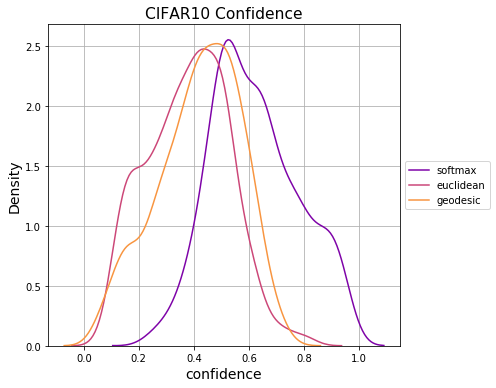

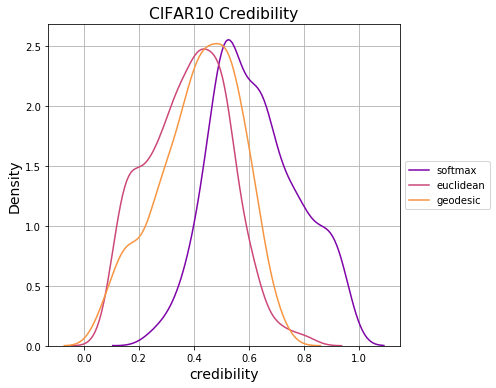

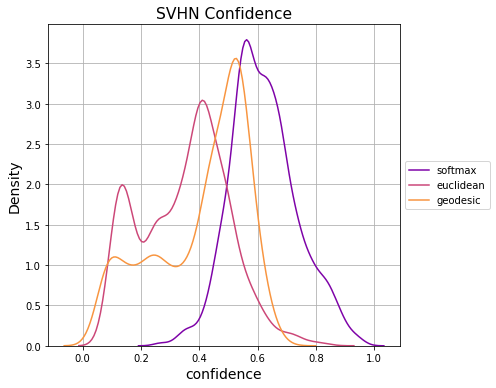

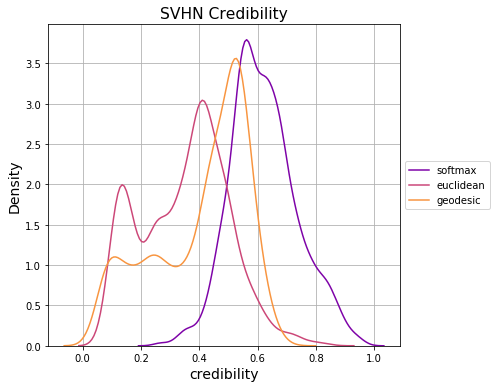

In [15]:
import seaborn as sns
def plot_distributions(distributions_dict, xlabel, fig_title):
    n_distributioins = len(distributions_dict.keys())
    fig, ax = plt.subplots(1, figsize=(7,5.5))
    plt.subplots_adjust(wspace=0.35)
    colors = sns.color_palette('plasma', len(distributions_dict.keys()))
    
    for idx, dist_name in enumerate(distributions_dict.keys()):
        train_dist_plot = sns.kdeplot(distributions_dict[dist_name],
                                     bw='silverman',
                                     label=dist_name,
                                     color=colors[idx])
        ax.set_xlabel(xlabel, fontsize=14)
        ax.set_ylabel('Density', fontsize=14)
        ax.set_title(fig_title, fontsize=15.5)
        ax.grid(True)
        ax.legend(loc='center left', bbox_to_anchor=(1,0.5))
    fig.tight_layout()
    plt.show()
    
confs = []
for i in range(len(conf_softmax)):
    confs.append(
                {
                'softmax':conf_softmax[i],
                'euclidean':conf_dknn[i],
                'geodesic':conf_geod[i],
            })
creds = []
for i in range(len(conf_softmax)):
    creds.append(
                {
                'softmax':conf_softmax[i],
                'euclidean':conf_dknn[i],
                'geodesic':conf_geod[i],
            })
plot_distributions(confs[0], 'confidence', 'CIFAR10 Confidence')
plot_distributions(creds[0], 'credibility', 'CIFAR10 Credibility')
plot_distributions(confs[1], 'confidence', 'SVHN Confidence')
plot_distributions(creds[1], 'credibility', 'SVHN Credibility')

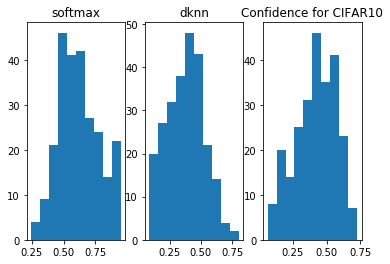

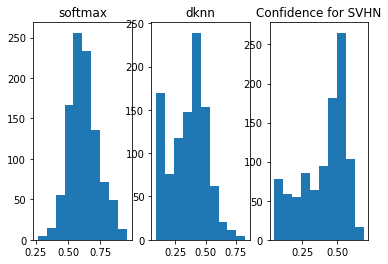

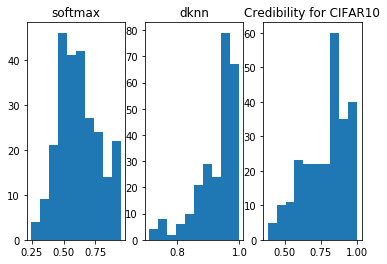

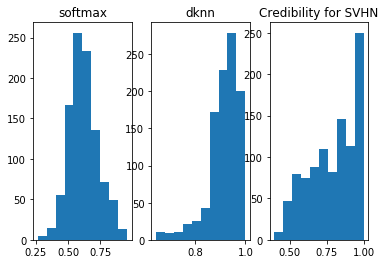

In [14]:
from matplotlib import pyplot as plt

dic = {0: 'CIFAR10', 1:'SVHN'}

for i in range(len(conf_softmax)):
#     print(conf_softmax[i].shape)
#     print(conf_dknn[i].shape)
#     print(conf_geod[i].shape)
    fig, ax = plt.subplots(1,3)
    ax[0].hist(conf_softmax[i])
    ax[0].set_title('softmax')
    ax[1].hist(conf_dknn[i])
    ax[1].set_title('dknn')
    ax[2].hist(conf_geod[i])
    ax[2].set_title('geod')
    plt.title('Confidence for {}'.format(dic[i]))
#     plt.savefig('{}.png'.format(dic[i]))
    plt.show()
    
for i in range(len(cred_softmax)):
#     print(conf_softmax[i].shape)
#     print(conf_dknn[i].shape)
#     print(conf_geod[i].shape)
    fig, ax = plt.subplots(1,3)
    ax[0].hist(cred_softmax[i])
    ax[0].set_title('softmax')
    ax[1].hist(cred_dknn[i])
    ax[1].set_title('dknn')
    ax[2].hist(cred_geod[i])
    ax[2].set_title('geod')
    plt.title('Credibility for {}'.format(dic[i]))
#     plt.savefig('{}.png'.format(dic[i]))
    plt.show()
